<a href="https://colab.research.google.com/github/manlio99/DeTodoUnPoco/blob/main/Unet_Image_segmentation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Image segmentation with CamVid

https://medium.com/analytics-vidhya/image-segmentation-using-fastai-ddded25f811e

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !pip install fastdebug

# from fastdebug import *

In [4]:
# !curl https://course.fast.ai/setup/colab | bash

In [5]:
!pip install torch==1.4 torchvision==0.5.0
!pip install fastai==1.0.61 

     |████████████████████████████████| 753.4 MB 6.9 kB/s 
     |████████████████████████████████| 4.0 MB 42.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.4.0 which is incompatible.


In [6]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [7]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.7.12
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.4.0
nvidia driver : 460.32
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Sat Jun 5 09:50:34 PDT 2021
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython

Wed Oct  6 18:46:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+---

In [8]:
path_lbl = "/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/"
path_lbl2 = "/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/rgb_etiqueta_molar_premolar_caninos_incisivos/"
path_img = "/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/"


## Data

In [9]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/0.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/1.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/2.png')]

In [10]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/0.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/1.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/2.png')]

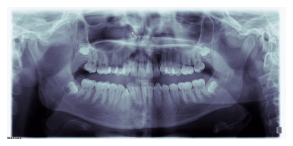

In [11]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [12]:
img.data.max()

tensor(1.)

In [13]:
# get_y_fn = lambda x: x
get_y_fn = lambda x: path_lbl+f'{x.stem}{x.suffix}'

In [14]:
img_f

PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/0.png')

In [15]:
get_y_fn(img_f)

'/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/0.png'

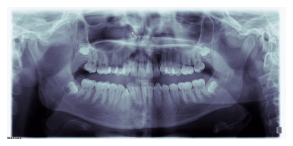

In [16]:
img = open_image(img_f)
img.show(figsize=(5,5))

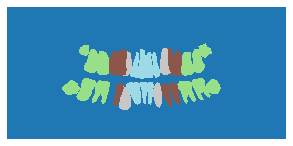

In [17]:
# mask = open_mask(get_y_fn(img_f))
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

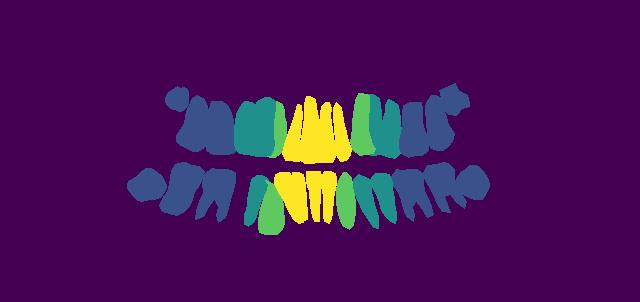

In [18]:
mask

In [19]:
mask.data.max()

tensor(4)

In [20]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([302, 640]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [21]:
codes = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/labels.txt', dtype = str)
# codes = np.array(["molares", "premolares", "caninos", "incisivos"], dtype=str)
codes

array(['encia', 'molares', 'premolares', 'caninos', 'incisivos'], dtype='<U10')

## Datasets

In [22]:
size = 420, 640 #170, 256 # 420, 640 224*2 #(3, 302, 640)# src_size  #(360, 480) //2

free = gpu_mem_get_free_no_cache()
# if free > 8200: 
#   bs=8
# else:
#   bs=4
bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")
size

using bs=4, have 11438 MB of GPU RAM free


(420, 640)

In [23]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(seed=1995)
       .label_from_func( get_y_fn, classes=codes)
       )
# .split_by _fname_file('../valid.txt')  .split_none()

In [24]:
# src = (SegmentationItemList.from_folder(path_img)
#         .split_by_rand_pct(seed=1995)
#        .label_from_func( get_y_fn, classes=codes)
#        )
# # .split_by _fname_file('../valid.txt')  .split_none()

In [25]:
src.transform(size=size, tfm_y=True)
src.get_processors

<bound method LabelLists.get_processors of LabelLists;

Train: LabelList (44 items)
x: SegmentationItemList
Image (3, 420, 640),Image (3, 420, 640),Image (3, 420, 640),Image (3, 420, 640),Image (3, 420, 640)
y: SegmentationLabelList
ImageSegment (1, 420, 640),ImageSegment (1, 420, 640),ImageSegment (1, 420, 640),ImageSegment (1, 420, 640),ImageSegment (1, 420, 640)
Path: /content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images;

Valid: LabelList (10 items)
x: SegmentationItemList
Image (3, 420, 640),Image (3, 420, 640),Image (3, 420, 640),Image (3, 420, 640),Image (3, 420, 640)
y: SegmentationLabelList
ImageSegment (1, 420, 640),ImageSegment (1, 420, 640),ImageSegment (1, 420, 640),ImageSegment (1, 420, 640),ImageSegment (1, 420, 640)
Path: /content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images;

Test: None>

In [26]:
tfms = get_transforms(flip_lr==True)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

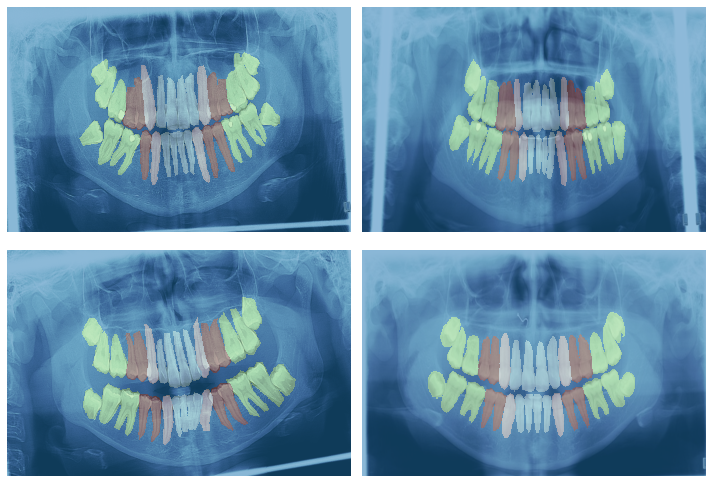

In [27]:
data.show_batch(2, figsize=(10, 7))

## Model

In [28]:
name2id = {v:k for k,v in enumerate(codes)}
aa={v:k for k,v in enumerate(codes) if k!=0}

void_code = name2id.values()
void_code2 = aa.values()
void_code2

dict_values([1, 2, 3, 4])

In [29]:

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# def foreground(input, target):
#     x = target.squeeze(1)
#     y = target != 0
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [30]:
# def JaccardCoeff2():
#     "Implementation of the Jaccard coefficient Dice=0"
#     return self.inter/(self.union-self.inter) if self.union > 0 else None

In [31]:
# metrics = acc_camvid

In [32]:
wd = 1e-2

In [33]:
# create unet
learn = unet_learner(data, models.resnet34, wd=wd)#metrics=metrics ,metrics=[acc_camvid,foreground]

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [34]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,1.838240,#na#,00:54
1,1.691823,#na#,00:26
2,1.427727,#na#,00:26
3,1.194286,#na#,00:26
4,1.022778,#na#,00:25
5,2.482359,#na#,00:25


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-05
Min loss divided by 10: 5.25E-04


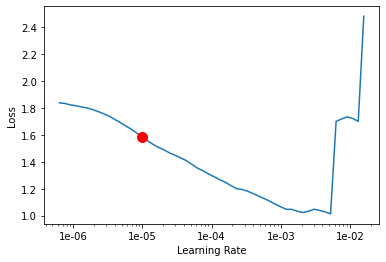

In [35]:
learn.recorder.plot(suggestion=True)

In [36]:
lr = 1e-4

In [37]:
learn.fit_one_cycle(20, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,time
0,1.395202,0.968766,00:39
1,1.164796,0.859877,00:30
2,1.033590,0.703512,00:30
3,0.919808,0.584706,00:30
4,0.820275,0.457758,00:29
5,0.720264,0.423077,00:30
6,0.640479,0.362257,00:30
7,0.572045,0.289902,00:29
8,0.510192,0.236815,00:29
9,0.453566,0.212587,00:29


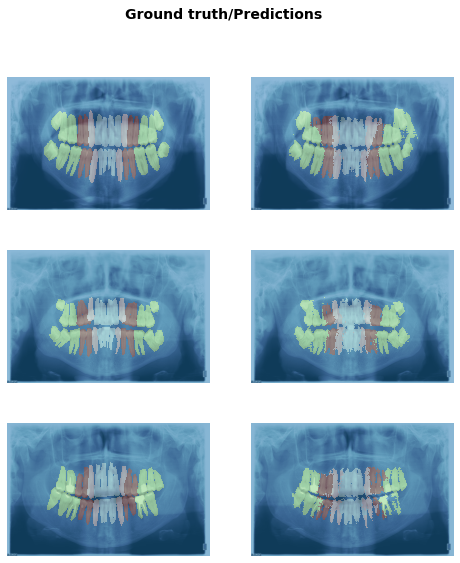

In [38]:
learn.show_results(rows=3, figsize=(8, 9))

In [39]:
learn.save('/content/drive/MyDrive/Colab Notebooks/odontologia/models/fastai_dientes_1_20')


# learn.load('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/fastai_dientes_1');



In [40]:
learn.unfreeze()

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.124538,#na#,00:29
1,0.125292,#na#,00:27
2,0.125086,#na#,00:27
3,0.144958,#na#,00:26
4,0.308375,#na#,00:26


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


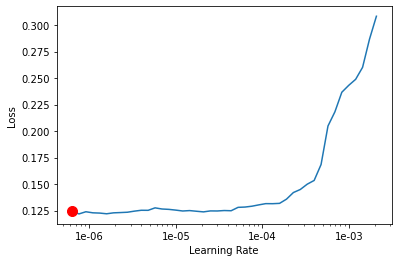

In [42]:
learn.recorder.plot(suggestion=True)

In [43]:
learn.fit_one_cycle(50, slice(1e-6, 1e-5), pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.127925,0.127885,00:31
1,0.128307,0.125186,00:31
2,0.127386,0.125257,00:30
3,0.124943,0.125126,00:31
4,0.125117,0.123600,00:30
5,0.123904,0.122352,00:31
6,0.121981,0.122155,00:31
7,0.122514,0.120830,00:30
8,0.121136,0.124398,00:31
9,0.119152,0.120481,00:31


epoch,train_loss,valid_loss,time
0,0.127925,0.127885,00:31
1,0.128307,0.125186,00:31
2,0.127386,0.125257,00:30
3,0.124943,0.125126,00:31
4,0.125117,0.123600,00:30
5,0.123904,0.122352,00:31
6,0.121981,0.122155,00:31
7,0.122514,0.120830,00:30
8,0.121136,0.124398,00:31
9,0.119152,0.120481,00:31


## prueba en test

---



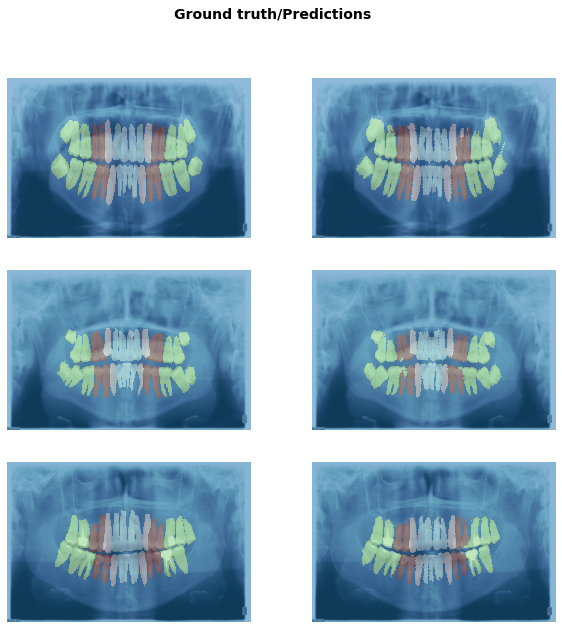

In [45]:
learn.show_results(rows=3, figsize=(10, 10))

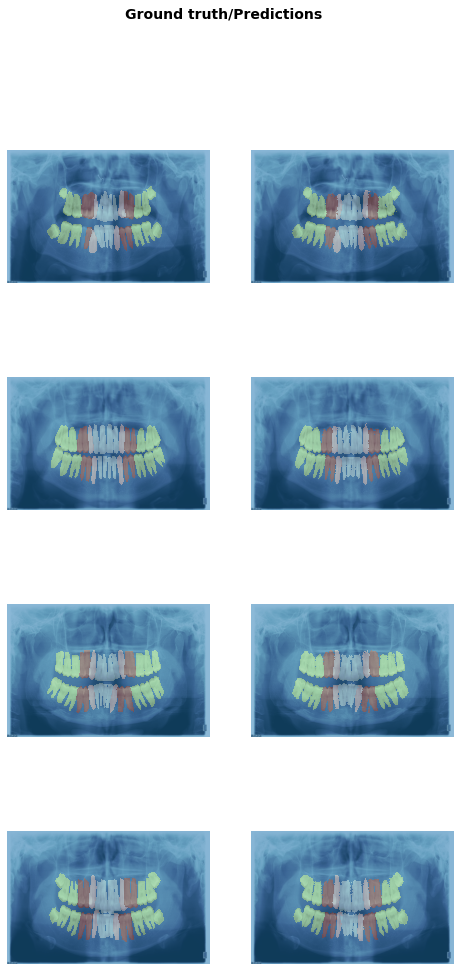

In [49]:
test_preds = learn.get_preds(ds_type=data.test_ds)
learn.show_results(test_preds)

In [ ]:
learn.save('/content/drive/MyDrive/Colab Notebooks/odontologia/models/fastai_dientes_2_20')


# learn.load('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/fastai_dientes_2');

In [ ]:
learn.destroy()

### Train with custom loss

In [ ]:
size = 170, 256 # 420, 640 224*2 #(3, 302, 640)# src_size  #(360, 480) //2

free = gpu_mem_get_free_no_cache()
# if free > 8200: 
#   bs=8
# else:
#   bs=4
bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")
size

In [ ]:
# get_y_fn = lambda x: x
get_y_fn = lambda x: path_lbl2+f'{x.stem}{x.suffix}'

In [ ]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True, convert_mode='RGB') for 3 channel target masks

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, convert_mode='L', div=False)
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [ ]:
# define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_lr==True)

src = (SegItemListCustom.from_folder(path_img)
        .split_by_rand_pct(seed=1995)
       .label_from_func( get_y_fn, classes=codes))

data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
# import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
        # pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        # print(output.shape)
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
                ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,0,None])
            loss+=ch_wt*(ch_loss)
        return loss/sum(self.ch_wts)

In [ ]:
# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels

def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

In [ ]:
# set up metrics to show mean metrics for all channels as well as the building-only metrics (channel 0)

acc_ch0 = partial(acc_thresh_multich, one_ch=0)
dice_ch0 = partial(dice_multich, one_ch=0)
metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0]

In [ ]:
# combo Focal + Dice loss with equal channel wts
ch_wts = [0.1,1,1,1,1] #importancia de cada clase
print(len(ch_wts))
learn = unet_learner(data, models.resnet34, model_dir='../../models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1], #importancia de cada loss
                        ch_wts=ch_wts
                        )
                    )
learn.lr_find()

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 1e-3
learn.fit_one_cycle(10, max_lr=lr, 
                    # callbacks=[
                    #     SaveModelCallback(learn,
                    #                      monitor='dice_multich',
                    #                      mode='max',
                    #                      name='znz001trn-focaldice-stage1-best')
                    # ]
                   )

In [ ]:
#sin entrenar
learn.show_results(rows=3, figsize=(10, 10))

In [ ]:
learn.save('camvid-stage-2_20)

In [ ]:
learn.recorder.plot()

## Train on bigger images

In [ ]:
learn.destroy()

size = src_size // 1.5

free = gpu_mem_get_free_no_cache()
if free > 8200: 
  bs=3
else: 
  bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('camvid-stage-2_20');

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('camvid-big-stage-1_202')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, lr/10))

In [ ]:
learn.save('stage-2-big_4_20')

## interpretation

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))

In [ ]:
path_img_test = "/content/drive/MyDrive/Colab Notebooks/odontologia/images/OYARZO_LORENA_05092018_150555.jpg"
img = open_image(path_img_test)
img.show()
prediction = learn.predict(img)
img.show(y=prediction[0])

In [ ]:
test_preds = learn.get_preds(ds_type=DatasetType.Test)
learn.show_results(test_preds)

In [ ]:
testpath= "/content/drive/MyDrive/Colab Notebooks/odontologia/jsons_dientes_enumerados/test/OYARZO_LORENA_05092018_150555"
test = (SegmentationItemList.from_folder(testpath)
        .split_none()
       )
# test.transform(size=size, tfm_y=True)
data_test = (test.transform(size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data.add_test(data_test)

In [ ]:
preds, y = learn.get_preds(ds_type=data.Test)
mask = np.argmax(preds, axis=1)
mask.shape
plt.imshow(mask[0])